<a href="https://colab.research.google.com/github/kimagliardi/estatistica-probabilidade/blob/main/analise_api_fretes_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Estatística da API de Fretes Promocionais

Este notebook realiza uma análise estatística dos dados de uma API de cálculo de fretes promocionais, usada em um cenário de e-commerce.

Os dados vêm de duas fontes em formato CSV:

- **latência**: métricas de latência (p50) da API ao longo do tempo.
- **respostas por status code**: quantidade de requisições por código HTTP ao longo do tempo.

A análise é estruturada em três partes principais, seguindo os conteúdos da disciplina:

**A) Estatística descritiva**
- Medidas de tendência central (média, mediana, etc.)
- Medidas de dispersão (variância, desvio padrão, coeficiente de variação)
- Representação gráfica (histogramas, boxplots, séries temporais)
- Descritivo da distribuição de status codes

**B) Probabilidade e distribuições**
- Estimativa de probabilidades importantes para o negócio:
  - Probabilidade da latência ultrapassar 1 segundo
  - Probabilidade de resposta com status diferente de 200 (potencial perda de conversão)
- Análise exploratória da forma da distribuição (normalidade, cauda longa, etc.)
- Interpretação em termos de risco operacional e impacto nas campanhas de frete


Ao final, conectamos os resultados estatísticos com a interpretação de negócio:  
**onde podemos estar perdendo conversão por latência alta ou falhas da API**.


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# Deixar os gráficos mais bonitos
sns.set(style="whitegrid")

# === Leitura dos dados ===
latencia = pd.read_csv("latencia.csv")
status = pd.read_csv("respostas-por-status-code.csv")

# Visualização inicial
print("Latência - primeiras linhas:")
display(latencia.head())

print("\nStatus codes - primeiras linhas:")
display(status.head())

print("\nColunas latência:", latencia.columns.tolist())
print("Colunas status:", status.columns.tolist())


Latência - primeiras linhas:


,query,group,time,value
0,p50:trace.fastapi.request{env:production AND s...,NaN,2025-11-10T03:00:00.000Z,0.011682
1,p50:trace.fastapi.request{env:production AND s...,NaN,2025-11-10T04:00:00.000Z,0.012238
2,p50:trace.fastapi.request{env:production AND s...,NaN,2025-11-10T05:00:00.000Z,0.011151
3,p50:trace.fastapi.request{env:production AND s...,NaN,2025-11-10T06:00:00.000Z,0.011325
4,p50:trace.fastapi.request{env:production AND s...,NaN,2025-11-10T07:00:00.000Z,0.011502



Status codes - primeiras linhas:


,query,group,time,value
0,sum:trace.fastapi.request.hits.by_http_status{...,http.status_code:200,2025-11-10T03:00:00.000Z,10152.0
1,sum:trace.fastapi.request.hits.by_http_status{...,http.status_code:200,2025-11-10T04:00:00.000Z,7912.0
2,sum:trace.fastapi.request.hits.by_http_status{...,http.status_code:200,2025-11-10T05:00:00.000Z,5987.0
3,sum:trace.fastapi.request.hits.by_http_status{...,http.status_code:200,2025-11-10T06:00:00.000Z,5257.0
4,sum:trace.fastapi.request.hits.by_http_status{...,http.status_code:200,2025-11-10T07:00:00.000Z,5698.0



Colunas latência: ['query', 'group', 'time', 'value']
Colunas status: ['query', 'group', 'time', 'value']


## 1. Preparação e entendimento dos dados

Os arquivos possuem, de forma geral, as seguintes colunas:

### Tabela de latência (`latencia`)

- `query`: consulta usada na ferramenta de observabilidade (ex: p50:trace.fastapi.request{...}).
- `group`: não está sendo usada neste conjunto (NaN).
- `time`: timestamp (em UTC) da métrica.
- `value`: valor numérico da métrica de latência (p50) naquele horário, em **segundos**.

### Tabela de status codes (`status`)

- `query`: consulta usada na ferramenta de observabilidade (contagem de requisições por status).
- `group`: identificador do status HTTP (ex: `http.status_code:200`, `http.status_code:500`).
- `time`: timestamp (em UTC) da janela de agregação.
- `value`: quantidade de requisições com aquele status naquele horário.

A partir daqui, vamos:

1. Converter colunas de tempo para `datetime`.
2. Criar variáveis mais amigáveis (por exemplo, extrair o código HTTP como inteiro).
3. Ter certeza de que não há valores faltantes ou problemas simples de qualidade de dados.


In [61]:
# Conversão de time para datetime
latencia['time'] = pd.to_datetime(latencia['time'])
status['time'] = pd.to_datetime(status['time'])

# Criar uma coluna com o código HTTP como número inteiro
def extrair_status_code(x):
    # exemplo: "http.status_code:200" -> 200
    try:
        return int(str(x).split(":")[-1])
    except:
        return np.nan

status['status_code'] = status['group'].apply(extrair_status_code)


# Ordenar por tempo (só para garantir)
latencia = latencia.sort_values('time')
status = status.sort_values('time')

print("\nPeríodo de análise - Latência:")
print(latencia['time'].min(), "->", latencia['time'].max())

print("\nPeríodo de análise - Status:")
print(status['time'].min(), "->", status['time'].max())



Período de análise - Latência:
2025-11-10 03:00:00+00:00 -> 2025-12-11 02:00:00+00:00

Período de análise - Status:
2025-11-10 03:00:00+00:00 -> 2025-12-11 02:00:00+00:00


## 2. Estatística descritiva da latência

Nesta seção vamos:

- Calcular medidas de tendência central: **média, mediana, mínimo, máximo**.
- Calcular medidas de dispersão: **variância, desvio padrão, coeficiente de variação**.
- Visualizar a distribuição com:
  - histograma
  - boxplot
  - série temporal

Do ponto de vista de negócio:

- Queremos entender se a latência (p50) está confortavelmente abaixo de 1s.
- Queremos ver se há **picos** anormais de latência (cauda longa).
- Maior dispersão e assimetria indicam risco de, em alguns momentos, **não aplicar campanhas de frete (ex: frete grátis)** por ultrapassar o limite de tempo.


In [62]:
# Estatística descritiva básica da latência
lat_values = latencia['value']  # em segundos

descr_lat = lat_values.describe()
print("Estatísticas descritivas da latência (segundos):")
display(descr_lat)

# Medidas adicionais
media = lat_values.mean()
mediana = lat_values.median()
variancia = lat_values.var()
desvio_padrao = lat_values.std()
coef_var = desvio_padrao / media if media != 0 else np.nan

print("\nMedidas adicionais:")
print(f"Média: {media:.6f} s")
print(f"Mediana: {mediana:.6f} s")
print(f"Variância: {variancia:.6f}")
print(f"Desvio padrão: {desvio_padrao:.6f}")
print(f"Coeficiente de variação: {coef_var:.4f}")


Estatísticas descritivas da latência (segundos):


,value
count,3720.000000
mean,0.062408
std,0.280313
min,0.010319
25%,0.024587
50%,0.034581
75%,0.055921
max,16.805932



Medidas adicionais:
Média: 0.062408 s
Mediana: 0.034581 s
Variância: 0.078575
Desvio padrão: 0.280313
Coeficiente de variação: 4.4916


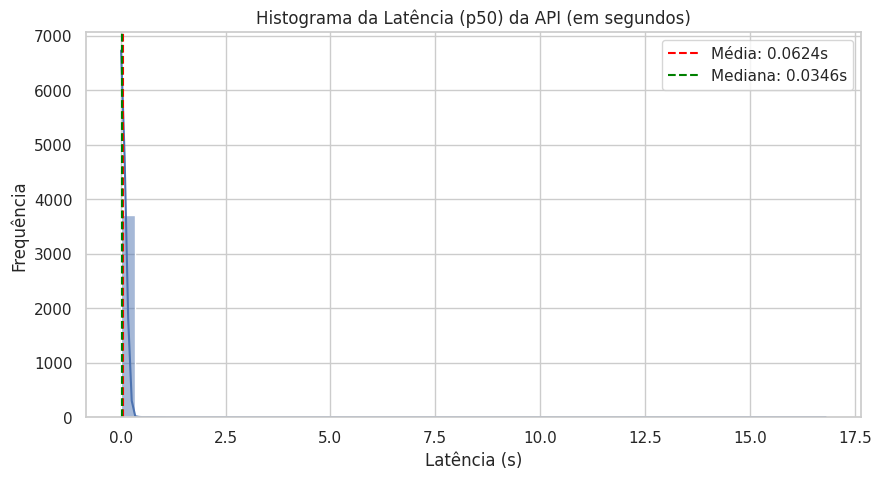

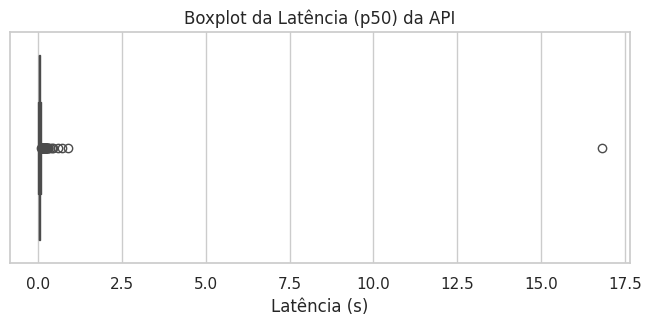

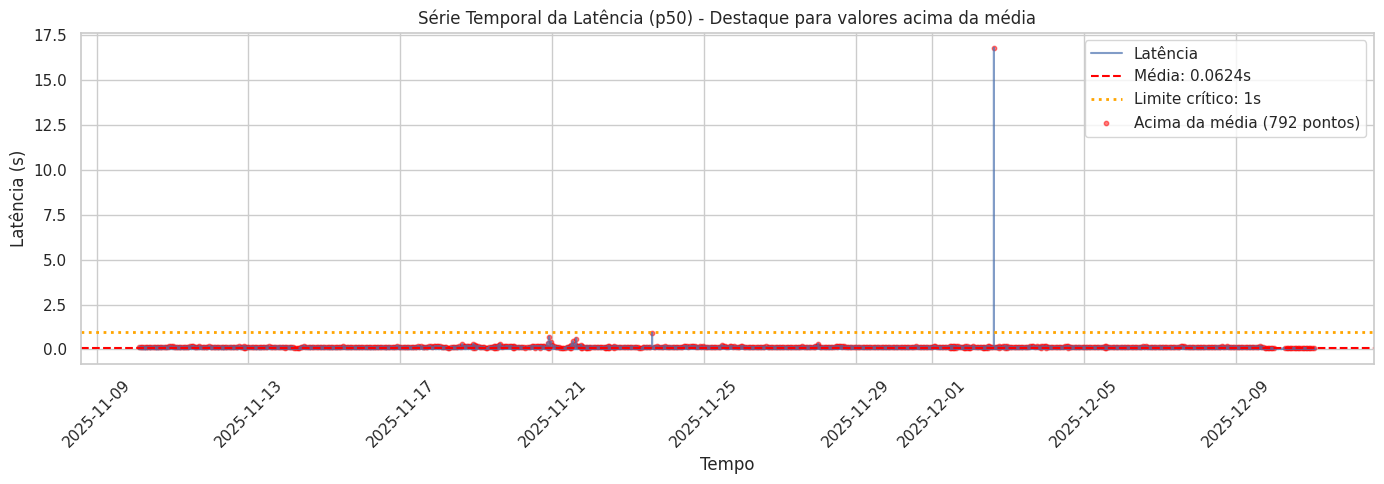


=== Análise dos momentos com latência acima da média (0.0624s) ===
Total de pontos acima da média: 792 de 3720 (21.29%)


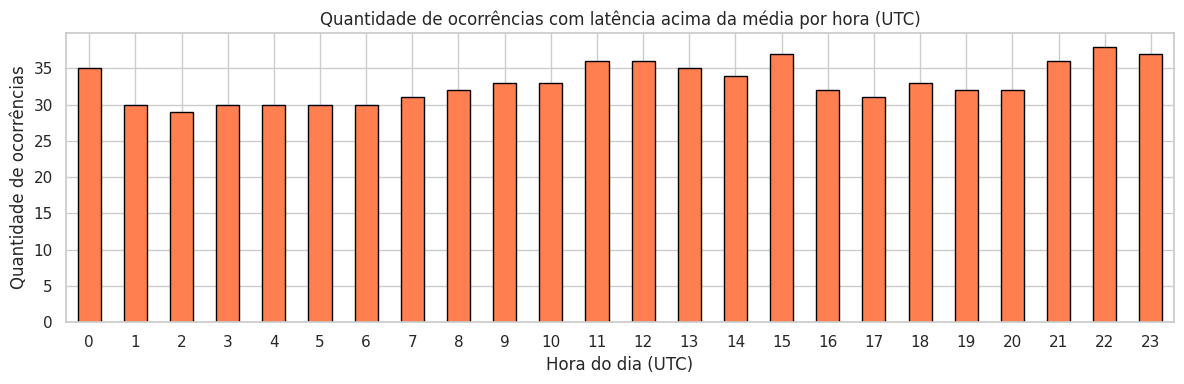


=== Top 10 momentos com maior latência ===


,time,value
3516,2025-12-02 15:00:00+00:00,16.8059s
3300,2025-11-23 15:00:00+00:00,0.9111s
3235,2025-11-20 22:00:00+00:00,0.7110s
3252,2025-11-21 15:00:00+00:00,0.6089s
3250,2025-11-21 13:00:00+00:00,0.4535s
3236,2025-11-20 23:00:00+00:00,0.4262s
3234,2025-11-20 21:00:00+00:00,0.3594s
3405,2025-11-28 00:00:00+00:00,0.3175s
3204,2025-11-19 15:00:00+00:00,0.3126s
3251,2025-11-21 14:00:00+00:00,0.2893s


In [63]:
# Histograma da latência
plt.figure(figsize=(10,5))
sns.histplot(lat_values, bins=50, kde=True)
plt.axvline(media, color='red', linestyle='--', label=f'Média: {media:.4f}s')
plt.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.4f}s')
plt.title("Histograma da Latência (p50) da API (em segundos)")
plt.xlabel("Latência (s)")
plt.ylabel("Frequência")
plt.legend()
plt.show()

# Boxplot da latência
plt.figure(figsize=(8,3))
sns.boxplot(x=lat_values)
plt.title("Boxplot da Latência (p50) da API")
plt.xlabel("Latência (s)")
plt.show()

# Série temporal da latência COM destaque para momentos acima da média
plt.figure(figsize=(14,5))
plt.plot(latencia['time'], lat_values, alpha=0.7, label='Latência')
plt.axhline(media, color='red', linestyle='--', linewidth=1.5, label=f'Média: {media:.4f}s')
plt.axhline(1.0, color='orange', linestyle=':', linewidth=2, label='Limite crítico: 1s')

# Destacar pontos acima da média
acima_media = latencia[lat_values > media]
plt.scatter(acima_media['time'], acima_media['value'], color='red', s=10, alpha=0.5, label=f'Acima da média ({len(acima_media)} pontos)')

plt.title("Série Temporal da Latência (p50) - Destaque para valores acima da média")
plt.xlabel("Tempo")
plt.ylabel("Latência (s)")
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Análise dos momentos com latência acima da média
print(f"\n=== Análise dos momentos com latência acima da média ({media:.4f}s) ===")
print(f"Total de pontos acima da média: {len(acima_media)} de {len(latencia)} ({len(acima_media)/len(latencia)*100:.2f}%)")

# Agrupar por hora do dia (UTC)
latencia['hora_utc'] = latencia['time'].dt.hour
acima_media_por_hora = latencia[lat_values > media].groupby('hora_utc').size()

plt.figure(figsize=(12,4))
acima_media_por_hora.plot(kind='bar', color='coral', edgecolor='black')
plt.title("Quantidade de ocorrências com latência acima da média por hora (UTC)")
plt.xlabel("Hora do dia (UTC)")
plt.ylabel("Quantidade de ocorrências")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Top 10 piores momentos
print("\n=== Top 10 momentos com maior latência ===")
top10 = latencia.nlargest(10, 'value')[['time', 'value']].copy()
top10['value'] = top10['value'].apply(lambda x: f"{x:.4f}s")
display(top10)

## 3. Estatística descritiva dos status codes

Agora vamos olhar para a **distribuição dos códigos HTTP**:

- Quantas requisições retornam **200**?
- Qual a proporção de códigos diferentes de 200 (erros ou situações não ideais)?
- Como isso varia ao longo do tempo?

Do ponto de vista de negócio:

- Cada status diferente de 200 pode representar uma **oportunidade perdida de conversão**:
  - Não aplicamos frete grátis
  - Não aplicamos desconto de frete
  - Não aplicamos “closeness” (regra de aproximação de preço)
- Mesmo que a taxa de erro seja pequena, em grandes volumes de tráfego isso pode representar um número significativo de pedidos perdidos.


=== Resumo Geral dos Status Codes ===
Total de requisições no período: 19,943,765
Período: 2025-11-10 03:00:00+00:00 até 2025-12-11 02:00:00+00:00

✅ Requisições com sucesso (200): 19,941,964 (99.99%)
❌ Requisições com erro (!= 200): 1,801 (0.01%)

=== Detalhamento por Status Code ===


,Requisições,Percentual (%)
status_code,,
200,19941964.0,99.9910
500,1155.0,0.0058
201,325.0,0.0016
307,133.0,0.0007
404,105.0,0.0005
400,51.0,0.0003
204,22.0,0.0001
409,5.0,0.0000
401,4.0,0.0000


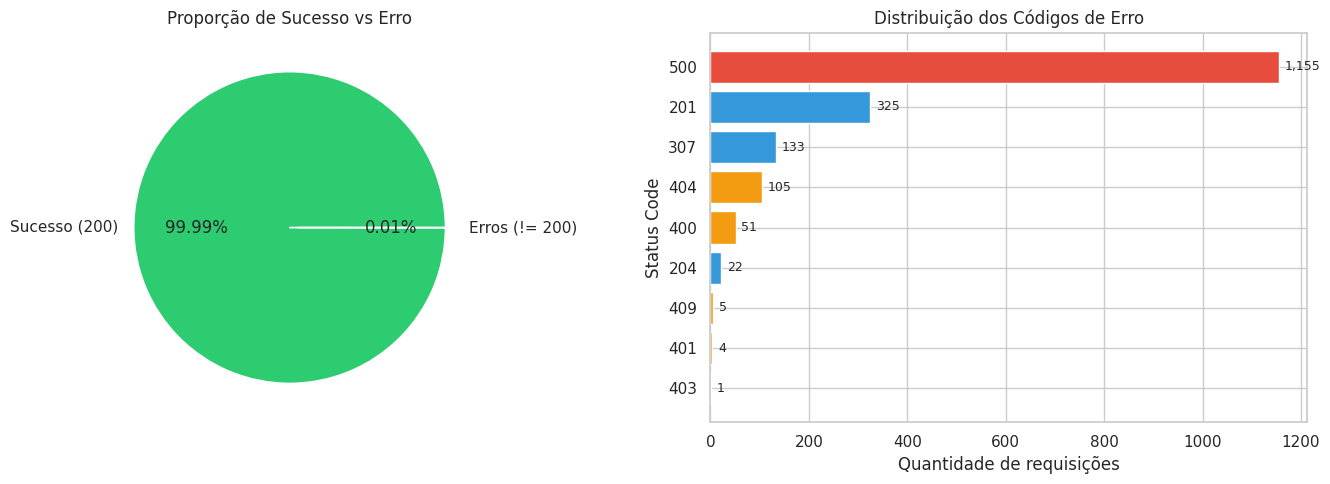


=== Análise Temporal dos Erros ===


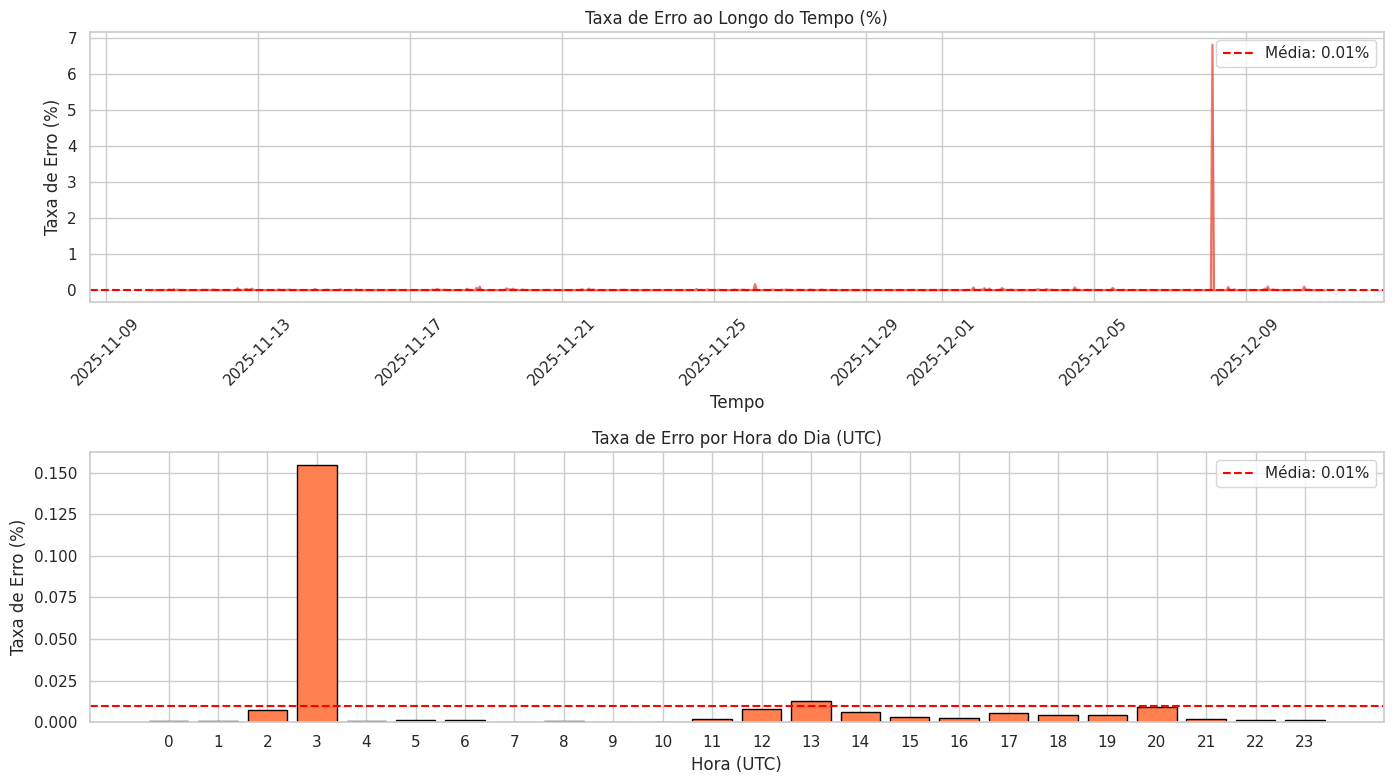

Taxa de erro média: 0.0127%
Taxa de erro máxima: 6.8210%
Desvio padrão da taxa de erro: 0.2502%

=== Top 10 Momentos com Mais Erros (Horário de Brasília) ===


,Data,Dia da Semana,Hora (BRT),Quantidade de Erros
0,08/12/2025,Segunda,00:00,1093
1,25/11/2025,Terça,23:00,54
2,18/11/2025,Terça,17:00,25
3,10/12/2025,Quarta,10:00,23
4,09/12/2025,Terça,11:00,23
5,08/12/2025,Segunda,10:00,19
6,18/11/2025,Terça,15:00,16
7,01/12/2025,Segunda,17:00,16
8,04/12/2025,Quinta,09:00,15
9,03/12/2025,Quarta,10:00,14



=== Erros por Dia da Semana ===


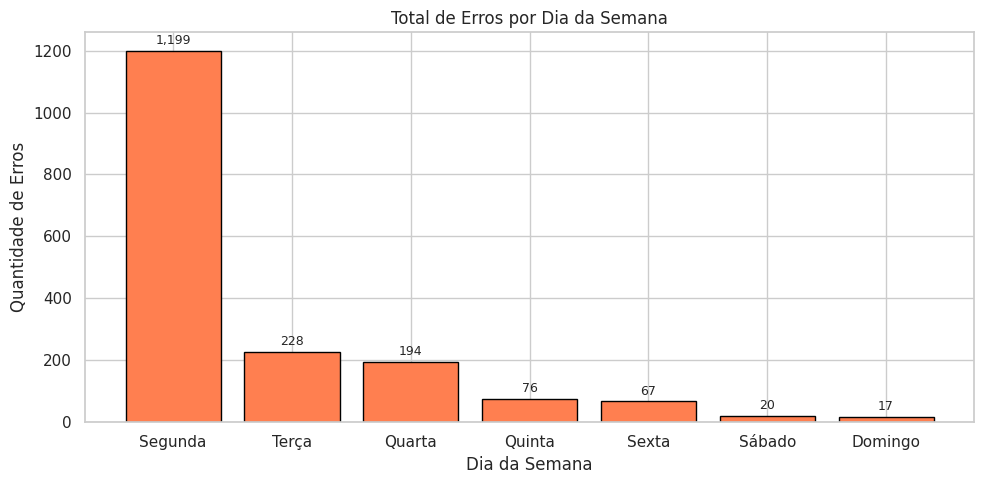


=== Mapa de Calor: Erros por Dia da Semana e Hora (Horário de Brasília) ===


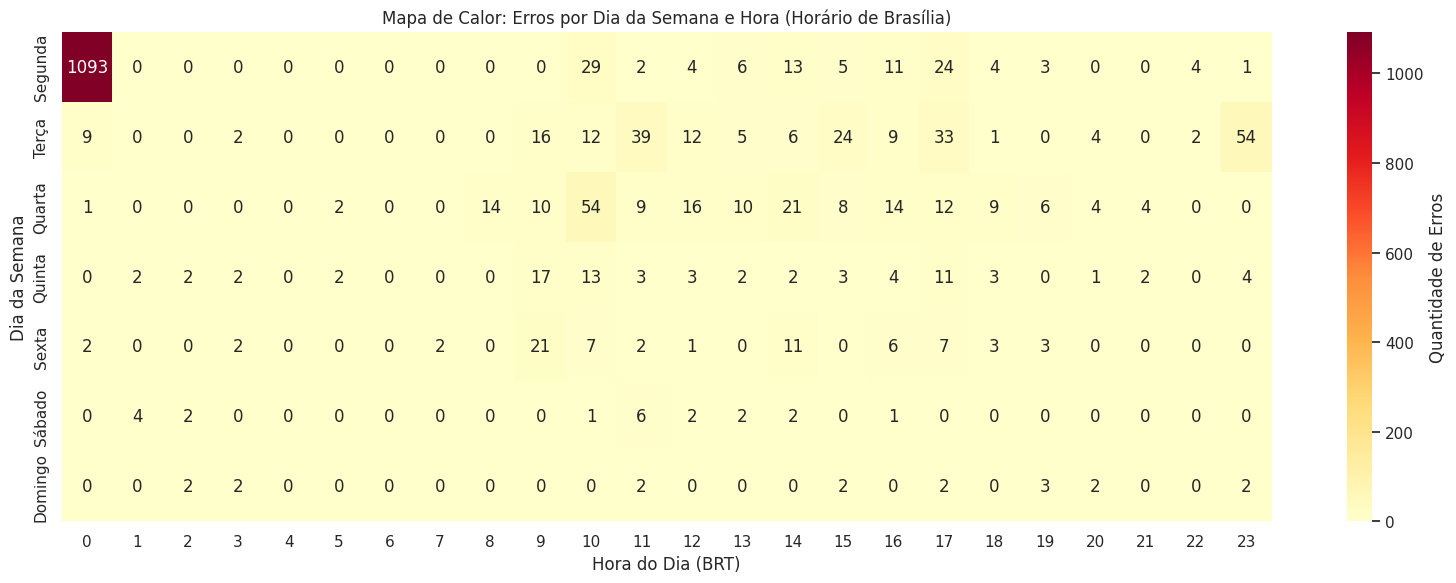


=== Impacto Estimado no Negócio ===
Total de requisições com erro: 1,801
Se cada erro representa uma potencial perda de conversão de frete promocional,
isso significa 1,801 oportunidades potencialmente perdidas no período.


In [64]:
# Agregar total de requisições por status code
status_totais = status.groupby('status_code')['value'].sum().sort_values(ascending=False)
total_requisicoes = status_totais.sum()

print("=== Resumo Geral dos Status Codes ===")
print(f"Total de requisições no período: {total_requisicoes:,.0f}")
print(f"Período: {status['time'].min()} até {status['time'].max()}")

# Separar sucessos de erros
requisicoes_200 = status_totais.get(200, 0)
requisicoes_erro = total_requisicoes - requisicoes_200

print(f"\n✅ Requisições com sucesso (200): {requisicoes_200:,.0f} ({requisicoes_200/total_requisicoes*100:.2f}%)")
print(f"❌ Requisições com erro (!= 200): {requisicoes_erro:,.0f} ({requisicoes_erro/total_requisicoes*100:.2f}%)")

# Detalhamento por status code
print("\n=== Detalhamento por Status Code ===")
status_df = pd.DataFrame({
    'Requisições': status_totais,
    'Percentual (%)': (status_totais / total_requisicoes * 100).round(4)
})
display(status_df)

# Gráfico de pizza para visão geral
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pizza: Sucesso vs Erro
axes[0].pie([requisicoes_200, requisicoes_erro],
            labels=['Sucesso (200)', 'Erros (!= 200)'],
            autopct='%1.2f%%',
            colors=['#2ecc71', '#e74c3c'],
            explode=[0, 0.05])
axes[0].set_title('Proporção de Sucesso vs Erro')

# Barras: Detalhamento dos erros (excluindo 200 para melhor visualização)
status_erros = status_totais[status_totais.index != 200].sort_values(ascending=True)
colors = ['#e74c3c' if code >= 500 else '#f39c12' if code >= 400 else '#3498db' for code in status_erros.index]
axes[1].barh(status_erros.index.astype(str), status_erros.values, color=colors)
axes[1].set_xlabel('Quantidade de requisições')
axes[1].set_ylabel('Status Code')
axes[1].set_title('Distribuição dos Códigos de Erro')
for i, v in enumerate(status_erros.values):
    axes[1].text(v + max(status_erros.values)*0.01, i, f'{v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# === Análise temporal dos erros ===
print("\n=== Análise Temporal dos Erros ===")

# Criar série temporal de erros vs sucessos
status_pivot = status.pivot_table(index='time', columns='status_code', values='value', aggfunc='sum').fillna(0)

# Taxa de erro por intervalo de tempo
if 200 in status_pivot.columns:
    total_por_tempo = status_pivot.sum(axis=1)
    erros_por_tempo = total_por_tempo - status_pivot[200]
    taxa_erro_temporal = (erros_por_tempo / total_por_tempo * 100).replace([np.inf, -np.inf], np.nan).dropna()

    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    # Série temporal da taxa de erro
    axes[0].plot(taxa_erro_temporal.index, taxa_erro_temporal.values, color='#e74c3c', alpha=0.7)
    axes[0].axhline(taxa_erro_temporal.mean(), color='red', linestyle='--', label=f'Média: {taxa_erro_temporal.mean():.2f}%')
    axes[0].fill_between(taxa_erro_temporal.index, taxa_erro_temporal.values, alpha=0.3, color='#e74c3c')
    axes[0].set_title('Taxa de Erro ao Longo do Tempo (%)')
    axes[0].set_xlabel('Tempo')
    axes[0].set_ylabel('Taxa de Erro (%)')
    axes[0].legend()
    axes[0].tick_params(axis='x', rotation=45)

    # Erros por hora do dia
    status['hora_utc'] = status['time'].dt.hour
    erros_df = status[status['status_code'] != 200].groupby('hora_utc')['value'].sum()
    total_df = status.groupby('hora_utc')['value'].sum()
    taxa_erro_hora = (erros_df / total_df * 100).fillna(0)

    axes[1].bar(taxa_erro_hora.index, taxa_erro_hora.values, color='coral', edgecolor='black')
    axes[1].axhline(taxa_erro_hora.mean(), color='red', linestyle='--', label=f'Média: {taxa_erro_hora.mean():.2f}%')
    axes[1].set_title('Taxa de Erro por Hora do Dia (UTC)')
    axes[1].set_xlabel('Hora (UTC)')
    axes[1].set_ylabel('Taxa de Erro (%)')
    axes[1].set_xticks(range(24))
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Estatísticas da taxa de erro
    print(f"Taxa de erro média: {taxa_erro_temporal.mean():.4f}%")
    print(f"Taxa de erro máxima: {taxa_erro_temporal.max():.4f}%")
    print(f"Desvio padrão da taxa de erro: {taxa_erro_temporal.std():.4f}%")

# === Top 10 piores momentos (maior quantidade de erros) - COM DIA/HORA ===
print("\n=== Top 10 Momentos com Mais Erros (Horário de Brasília) ===")
erros_absolutos = status[status['status_code'] != 200].groupby('time')['value'].sum().sort_values(ascending=False)
top10_erros = erros_absolutos.head(10).reset_index()
top10_erros.columns = ['Horário (UTC)', 'Quantidade de Erros']

# Converter para horário de Brasília e extrair informações
top10_erros['Horário (Brasília)'] = top10_erros['Horário (UTC)'].dt.tz_convert('America/Sao_Paulo')

# Mapeamento de dias da semana para português
dias_semana = {0: 'Segunda', 1: 'Terça', 2: 'Quarta', 3: 'Quinta', 4: 'Sexta', 5: 'Sábado', 6: 'Domingo'}
top10_erros['Dia da Semana'] = top10_erros['Horário (Brasília)'].dt.dayofweek.map(dias_semana)
top10_erros['Data'] = top10_erros['Horário (Brasília)'].dt.strftime('%d/%m/%Y')
top10_erros['Hora (BRT)'] = top10_erros['Horário (Brasília)'].dt.strftime('%H:%M')

# Reorganizar colunas para melhor visualização
top10_display = top10_erros[['Data', 'Dia da Semana', 'Hora (BRT)', 'Quantidade de Erros']].copy()
top10_display['Quantidade de Erros'] = top10_display['Quantidade de Erros'].astype(int)
display(top10_display)

# === Análise por dia da semana ===
print("\n=== Erros por Dia da Semana ===")
status['time_brt'] = status['time'].dt.tz_convert('America/Sao_Paulo')
status['dia_semana'] = status['time_brt'].dt.dayofweek.map(dias_semana)
status['dia_semana_num'] = status['time_brt'].dt.dayofweek

erros_por_dia = status[status['status_code'] != 200].groupby(['dia_semana_num', 'dia_semana'])['value'].sum()
erros_por_dia = erros_por_dia.reset_index().sort_values('dia_semana_num')

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(erros_por_dia['dia_semana'], erros_por_dia['value'], color='coral', edgecolor='black')
ax.set_title('Total de Erros por Dia da Semana')
ax.set_xlabel('Dia da Semana')
ax.set_ylabel('Quantidade de Erros')
for bar, val in zip(bars, erros_por_dia['value']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(erros_por_dia['value'])*0.01,
            f'{int(val):,}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# === Heatmap: Dia da Semana x Hora ===
print("\n=== Mapa de Calor: Erros por Dia da Semana e Hora (Horário de Brasília) ===")
status['hora_brt'] = status['time_brt'].dt.hour
erros_heatmap = status[status['status_code'] != 200].pivot_table(
    index='dia_semana',
    columns='hora_brt',
    values='value',
    aggfunc='sum'
).fillna(0)

# Reordenar dias da semana
ordem_dias = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
erros_heatmap = erros_heatmap.reindex([d for d in ordem_dias if d in erros_heatmap.index])

plt.figure(figsize=(16, 6))
sns.heatmap(erros_heatmap, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Quantidade de Erros'})
plt.title('Mapa de Calor: Erros por Dia da Semana e Hora (Horário de Brasília)')
plt.xlabel('Hora do Dia (BRT)')
plt.ylabel('Dia da Semana')
plt.tight_layout()
plt.show()

# === Impacto no negócio ===
print("\n=== Impacto Estimado no Negócio ===")
print(f"Total de requisições com erro: {requisicoes_erro:,.0f}")
print(f"Se cada erro representa uma potencial perda de conversão de frete promocional,")
print(f"isso significa {requisicoes_erro:,.0f} oportunidades potencialmente perdidas no período.")

🛒 ANÁLISE BLACK FRIDAY 2025 - BRASIL

📊 Volume de Requisições por Período
----------------------------------------


,value
periodo,
Dias Normais,13716803.0
Black Week (24-27/11),3945322.0
Black Friday (28/11),1878116.0
Cyber Monday (01/12),403524.0



📈 Média de Requisições por Dia em cada Período:


,0
periodo,
Black Friday (28/11),1878116.00
Black Week (24-27/11),986330.50
Dias Normais,548672.12
Cyber Monday (01/12),403524.00



❌ Taxa de Erro por Período
----------------------------------------


,Total Requisições,Total Erros,Taxa de Erro (%)
periodo,,,
Dias Normais,13716803.0,1585.0,0.0116
Cyber Monday (01/12),403524.0,26.0,0.0064
Black Week (24-27/11),3945322.0,175.0,0.0044
Black Friday (28/11),1878116.0,15.0,0.0008


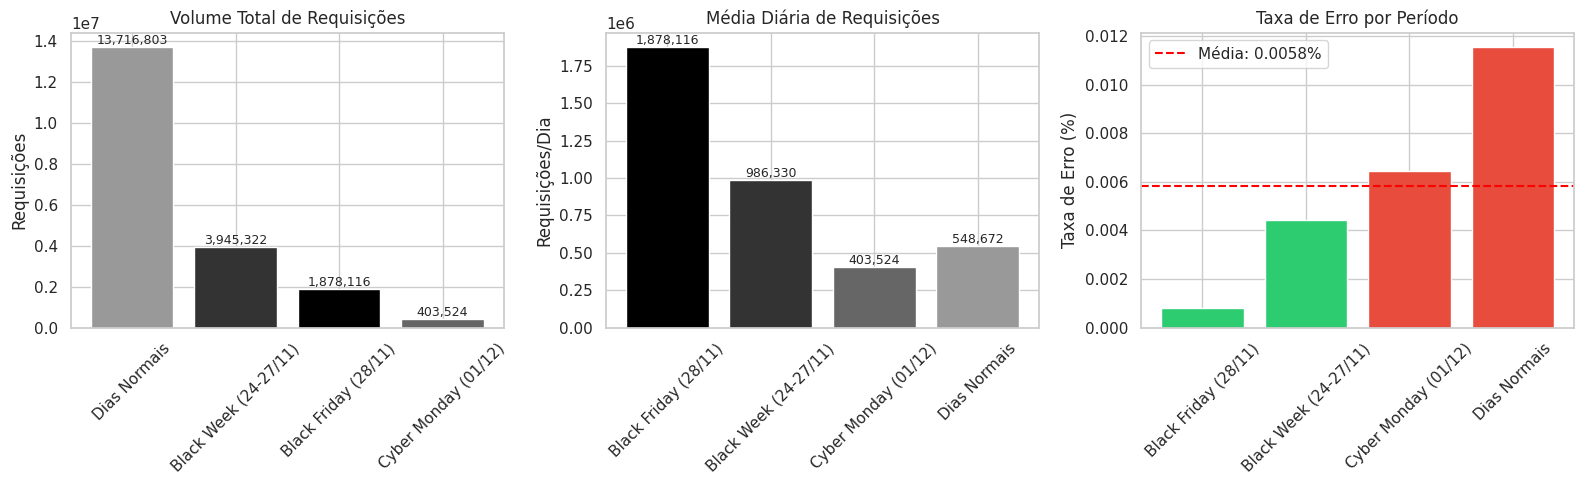


⏰ Análise Hora a Hora - Black Friday (28/11/2025)
----------------------------------------


/tmp/ipython-input-2205201273.py:137: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2205201273.py:137: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


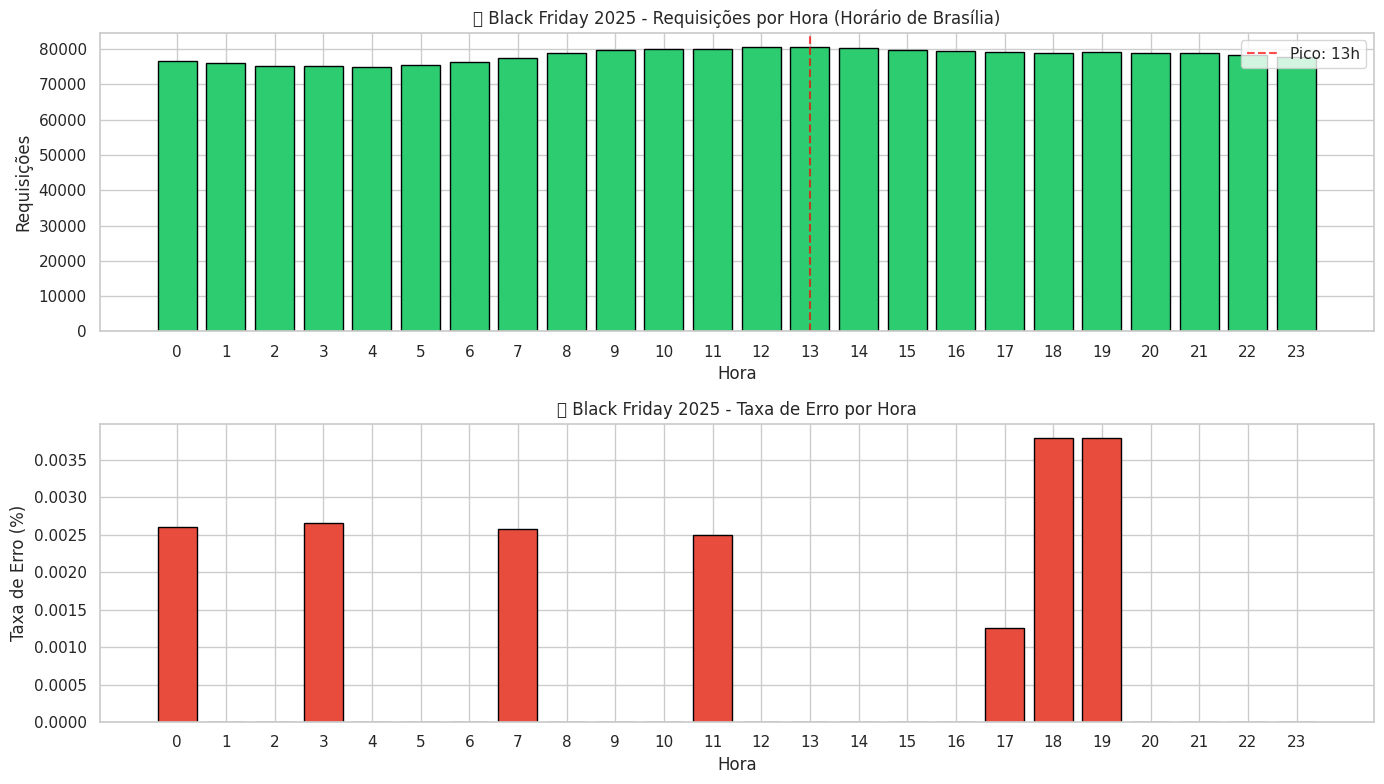


📋 Resumo da Black Friday 2025:
   • Total de requisições: 1,878,116
   • Total de erros: 15
   • Taxa de erro geral: 0.0008%
   • Horário de pico: 13h (80,587 requisições)

📊 Comparação com Dias Normais:
   • Requisições Black Friday: 1,878,116
   • Média dias normais: 548,672
   • Aumento: 242.3%

💡 INSIGHTS BLACK FRIDAY 2025

Com base na análise dos dados:

1. VOLUME DE TRÁFEGO
   - Compare o volume da Black Friday com dias normais
   - Identifique se houve preparação adequada de infraestrutura

2. TAXA DE ERRO
   - Erros maiores que a média podem indicar sobrecarga
   - Cada erro = potencial perda de conversão de frete promocional

3. HORÁRIOS CRÍTICOS
   - Identifique os picos de requisições
   - Horários com mais erros precisam de atenção especial

4. IMPACTO NO NEGÓCIO
   - Black Friday é o período mais crítico para e-commerce
   - Falhas na API de frete = clientes sem frete grátis/desconto
   - Isso pode significar carrinhos abandonados e vendas perdidas



In [65]:
# === Análise Black Friday 2025 ===
# A Black Friday no Brasil em 2025 foi no dia 28/11 (sexta-feira)
# Vamos analisar o período da Black Friday e comparar com dias normais

print("=" * 60)
print("🛒 ANÁLISE BLACK FRIDAY 2025 - BRASIL")
print("=" * 60)

# Definir período da Black Friday (28/11/2025)
# Considerando também a "Black Week" (24/11 a 28/11) e Cyber Monday (01/12)
from datetime import date

black_friday = date(2025, 11, 28)
black_week_inicio = date(2025, 11, 24)
cyber_monday = date(2025, 12, 1)

# Converter timestamps para comparação - extrair apenas a data
status['data_brt'] = status['time_brt'].dt.date

# Classificar períodos
def classificar_periodo(data_value):
    if data_value == black_friday:
        return 'Black Friday (28/11)'
    elif black_week_inicio <= data_value < black_friday:
        return 'Black Week (24-27/11)'
    elif data_value == cyber_monday:
        return 'Cyber Monday (01/12)'
    else:
        return 'Dias Normais'

status['periodo'] = status['data_brt'].apply(classificar_periodo)

# === Estatísticas de Requisições por Período ===
print("\n📊 Volume de Requisições por Período")
print("-" * 40)

requisicoes_periodo = status.groupby('periodo')['value'].sum().sort_values(ascending=False)
display(requisicoes_periodo)

# Calcular média diária por período
dias_por_periodo = status.groupby('periodo')['data_brt'].nunique()
media_diaria = requisicoes_periodo / dias_por_periodo

print("\n📈 Média de Requisições por Dia em cada Período:")
display(media_diaria.sort_values(ascending=False))

# === Taxa de Erro por Período ===
print("\n❌ Taxa de Erro por Período")
print("-" * 40)

erros_periodo = status[status['status_code'] != 200].groupby('periodo')['value'].sum()
taxa_erro_periodo = (erros_periodo / requisicoes_periodo * 100).fillna(0)

taxa_erro_df = pd.DataFrame({
    'Total Requisições': requisicoes_periodo,
    'Total Erros': erros_periodo,
    'Taxa de Erro (%)': taxa_erro_periodo.round(4)
}).sort_values('Taxa de Erro (%)', ascending=False)
display(taxa_erro_df)

# Gráfico comparativo
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Volume de requisições
cores_periodo = {'Black Friday (28/11)': '#000000', 'Black Week (24-27/11)': '#333333',
                 'Cyber Monday (01/12)': '#666666', 'Dias Normais': '#999999'}
cores = [cores_periodo.get(p, '#cccccc') for p in requisicoes_periodo.index]
axes[0].bar(requisicoes_periodo.index, requisicoes_periodo.values, color=cores)
axes[0].set_title('Volume Total de Requisições')
axes[0].set_ylabel('Requisições')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(requisicoes_periodo.values):
    axes[0].text(i, v + max(requisicoes_periodo.values)*0.01, f'{v:,.0f}', ha='center', fontsize=9)

# Média diária
cores_media = [cores_periodo.get(p, '#cccccc') for p in media_diaria.index]
axes[1].bar(media_diaria.index, media_diaria.values, color=cores_media)
axes[1].set_title('Média Diária de Requisições')
axes[1].set_ylabel('Requisições/Dia')
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(media_diaria.values):
    axes[1].text(i, v + max(media_diaria.values)*0.01, f'{v:,.0f}', ha='center', fontsize=9)

# Taxa de erro
cores_erro = ['#e74c3c' if v > taxa_erro_periodo.mean() else '#2ecc71' for v in taxa_erro_periodo.values]
axes[2].bar(taxa_erro_periodo.index, taxa_erro_periodo.values, color=cores_erro)
axes[2].axhline(taxa_erro_periodo.mean(), color='red', linestyle='--', label=f'Média: {taxa_erro_periodo.mean():.4f}%')
axes[2].set_title('Taxa de Erro por Período')
axes[2].set_ylabel('Taxa de Erro (%)')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend()

plt.tight_layout()
plt.show()

# === Análise Hora a Hora da Black Friday ===
print("\n⏰ Análise Hora a Hora - Black Friday (28/11/2025)")
print("-" * 40)

# Filtrar apenas Black Friday
bf_data = status[status['periodo'] == 'Black Friday (28/11)'].copy()

if len(bf_data) > 0:
    bf_por_hora = bf_data.groupby('hora_brt').agg({
        'value': 'sum',
        'status_code': lambda x: (x != 200).sum()  # contagem de registros com erro
    }).rename(columns={'value': 'requisicoes'})

    # Calcular erros reais (soma dos values quando status != 200)
    bf_erros_hora = bf_data[bf_data['status_code'] != 200].groupby('hora_brt')['value'].sum()
    bf_por_hora['erros'] = bf_erros_hora
    bf_por_hora['erros'] = bf_por_hora['erros'].fillna(0)
    bf_por_hora['taxa_erro'] = (bf_por_hora['erros'] / bf_por_hora['requisicoes'] * 100).fillna(0)

    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    # Requisições por hora
    axes[0].bar(bf_por_hora.index, bf_por_hora['requisicoes'], color='#2ecc71', edgecolor='black')
    axes[0].set_title('🛒 Black Friday 2025 - Requisições por Hora (Horário de Brasília)')
    axes[0].set_xlabel('Hora')
    axes[0].set_ylabel('Requisições')
    axes[0].set_xticks(range(24))

    # Destacar horários de pico
    pico = bf_por_hora['requisicoes'].idxmax()
    axes[0].axvline(pico, color='red', linestyle='--', alpha=0.7, label=f'Pico: {pico}h')
    axes[0].legend()

    # Taxa de erro por hora
    cores_hora = ['#e74c3c' if v > 0 else '#2ecc71' for v in bf_por_hora['taxa_erro']]
    axes[1].bar(bf_por_hora.index, bf_por_hora['taxa_erro'], color=cores_hora, edgecolor='black')
    axes[1].set_title('❌ Black Friday 2025 - Taxa de Erro por Hora')
    axes[1].set_xlabel('Hora')
    axes[1].set_ylabel('Taxa de Erro (%)')
    axes[1].set_xticks(range(24))

    plt.tight_layout()
    plt.show()

    # Resumo da Black Friday
    print("\n📋 Resumo da Black Friday 2025:")
    print(f"   • Total de requisições: {bf_por_hora['requisicoes'].sum():,.0f}")
    print(f"   • Total de erros: {bf_por_hora['erros'].sum():,.0f}")
    print(f"   • Taxa de erro geral: {(bf_por_hora['erros'].sum() / bf_por_hora['requisicoes'].sum() * 100):.4f}%")
    print(f"   • Horário de pico: {pico}h ({bf_por_hora.loc[pico, 'requisicoes']:,.0f} requisições)")

    # Comparar com média de dias normais
    dias_normais = status[status['periodo'] == 'Dias Normais']
    media_normal = dias_normais.groupby(dias_normais['data_brt'])['value'].sum().mean()

    print(f"\n📊 Comparação com Dias Normais:")
    print(f"   • Requisições Black Friday: {bf_por_hora['requisicoes'].sum():,.0f}")
    print(f"   • Média dias normais: {media_normal:,.0f}")
    print(f"   • Aumento: {((bf_por_hora['requisicoes'].sum() / media_normal - 1) * 100):.1f}%")
else:
    print("⚠️ Dados da Black Friday não encontrados no período analisado.")

# === Insights Finais ===
print("\n" + "=" * 60)
print("💡 INSIGHTS BLACK FRIDAY 2025")
print("=" * 60)
print("""
Com base na análise dos dados:

1. VOLUME DE TRÁFEGO
   - Compare o volume da Black Friday com dias normais
   - Identifique se houve preparação adequada de infraestrutura

2. TAXA DE ERRO
   - Erros maiores que a média podem indicar sobrecarga
   - Cada erro = potencial perda de conversão de frete promocional

3. HORÁRIOS CRÍTICOS
   - Identifique os picos de requisições
   - Horários com mais erros precisam de atenção especial

4. IMPACTO NO NEGÓCIO
   - Black Friday é o período mais crítico para e-commerce
   - Falhas na API de frete = clientes sem frete grátis/desconto
   - Isso pode significar carrinhos abandonados e vendas perdidas
""")

## 4. Probabilidades importantes para o negócio

Nesta etapa vamos estimar duas probabilidades chaves:

1. **Probabilidade da latência ultrapassar 1 segundo**  
   - Interpretação: fração de momentos em que a API está “lenta demais” para aplicar campanhas de frete (por exemplo, frete grátis é cancelado se o cálculo passar de 1s).

2. **Probabilidade de resposta diferente de 200**  
   - Interpretação: fração das requisições que potencialmente representam perda de conversão (erro de API, falha na aplicação da campanha, etc.).

Além disso, vamos olhar a **forma da distribuição** da latência:

- A distribuição é aproximadamente Normal?
- Existe cauda longa (alguns poucos pontos com latência muito alta)?
- Isso é coerente com sistemas de filas e tempos de resposta de APIs (muitas requisições rápidas, poucas muito lentas).

Essas análises se conectam diretamente ao conteúdo de **modelos de distribuições de probabilidade** e **probabilidade aplicada**.


In [66]:
# Probabilidade de latência > 1 segundo
p_lat_maior_1s = (lat_values > 1.0).mean()

print(f"Probabilidade estimada de latência > 1s: {p_lat_maior_1s*100:.4f}%")

# Alguns quantis relevantes (p95, p99)
p95 = lat_values.quantile(0.95)
p99 = lat_values.quantile(0.99)

print(f"Percentil 95 da latência: {p95:.4f} s")
print(f"Percentil 99 da latência: {p99:.4f} s")
print(f"Máximo observado: {lat_values.max():.4f} s")


Probabilidade estimada de latência > 1s: 0.0269%
Percentil 95 da latência: 0.1630 s
Percentil 99 da latência: 0.1845 s
Máximo observado: 16.8059 s
